# Lab 8: Define and Solve an ML Problem of Your Choosing

In [5]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns


ValueError: numpy.dtype size changed, may indicate binary incompatibility. Expected 96 from C header, got 88 from PyObject

In this lab assignment, you will follow the machine learning life cycle and implement a model to solve a machine learning problem of your choosing. You will select a data set and choose a predictive problem that the data set supports.  You will then inspect the data with your problem in mind and begin to formulate a  project plan. You will then implement the machine learning project plan. 

You will complete the following tasks:

1. Build Your DataFrame
2. Define Your ML Problem
3. Perform exploratory data analysis to understand your data.
4. Define Your Project Plan
5. Implement Your Project Plan:
    * Prepare your data for your model.
    * Fit your model to the training data and evaluate your model.
    * Improve your model's performance.

## Part 1: Build Your DataFrame

You will have the option to choose one of four data sets that you have worked with in this program:

* The "census" data set that contains Census information from 1994: `censusData.csv`
* Airbnb NYC "listings" data set: `airbnbListingsData.csv`
* World Happiness Report (WHR) data set: `WHR2018Chapter2OnlineData.csv`
* Book Review data set: `bookReviewsData.csv`

Note that these are variations of the data sets that you have worked with in this program. For example, some do not include some of the preprocessing necessary for specific models. 

#### Load a Data Set and Save it as a Pandas DataFrame

The code cell below contains filenames (path + filename) for each of the four data sets available to you.

<b>Task:</b> In the code cell below, use the same method you have been using to load the data using `pd.read_csv()` and save it to DataFrame `df`. 

You can load each file as a new DataFrame to inspect the data before choosing your data set.

In [ ]:
# File names of the four data sets
adultDataSet_filename = os.path.join(os.getcwd(), "data", "censusData.csv")
airbnbDataSet_filename = os.path.join(os.getcwd(), "data", "airbnbListingsData.csv")
WHRDataSet_filename = os.path.join(os.getcwd(), "data", "WHR2018Chapter2OnlineData.csv")
bookReviewDataSet_filename = os.path.join(os.getcwd(), "data", "bookReviewsData.csv")


df = pd.read_csv(bookReviewDataSet_filename)

df.head()


## Part 2: Define Your ML Problem

Next you will formulate your ML Problem. In the markdown cell below, answer the following questions:

1. List the data set you have chosen.
2. What will you be predicting? What is the label?
3. Is this a supervised or unsupervised learning problem? Is this a clustering, classification or regression problem? Is it a binary classificaiton or multi-class classifiction problem?
4. What are your features? (note: this list may change after your explore your data)
5. Explain why this is an important problem. In other words, how would a company create value with a model that predicts this label?

1.I am working on the Book Reviews dataset where each review includes text written by a reader and a label showing whether the review was positive or negative.

2.I’m predicting whether a review is positive or negative.
The label is the sentiment of the review (positive = 1, negative = 0).

This is a supervised learning and classification problem because we are training the model on labeled data because there are only two possible labels: positive or negative.

3.The feature being used is the text of the review.
I am going to turn this text into numbers using TF-IDF vectorization, which captures the importance of words in the reviews.

4. This ML problem is important because it helps companies understand how customers feel about their books.
A company (like Audible or Goodreads) can use this model to:

Automatically detect negative reviews to improve products, filter or highlight the most helpful reviews and generally get faster insights without needing a human to read every review. 

## Part 3: Understand Your Data

The next step is to perform exploratory data analysis. Inspect and analyze your data set with your machine learning problem in mind. Consider the following as you inspect your data:

1. What data preparation techniques would you like to use? These data preparation techniques may include:

    * addressing missingness, such as replacing missing values with means
    * finding and replacing outliers
    * renaming features and labels
    * finding and replacing outliers
    * performing feature engineering techniques such as one-hot encoding on categorical features
    * selecting appropriate features and removing irrelevant features
    * performing specific data cleaning and preprocessing techniques for an NLP problem
    * addressing class imbalance in your data sample to promote fair AI
    

2. What machine learning model (or models) you would like to use that is suitable for your predictive problem and data?
    * Are there other data preparation techniques that you will need to apply to build a balanced modeling data set for your problem and model? For example, will you need to scale your data?
 
 
3. How will you evaluate and improve the model's performance?
    * Are there specific evaluation metrics and methods that are appropriate for your model?
    

Think of the different techniques you have used to inspect and analyze your data in this course. These include using Pandas to apply data filters, using the Pandas `describe()` method to get insight into key statistics for each column, using the Pandas `dtypes` property to inspect the data type of each column, and using Matplotlib and Seaborn to detect outliers and visualize relationships between features and labels. If you are working on a classification problem, use techniques you have learned to determine if there is class imbalance.

<b>Task</b>: Use the techniques you have learned in this course to inspect and analyze your data. You can import additional packages that you have used in this course that you will need to perform this task.

<b>Note</b>: You can add code cells if needed by going to the <b>Insert</b> menu and clicking on <b>Insert Cell Below</b> in the drop-drown menu.


---

### 1 **What data preparation techniques will you use?**


To prepare the text data for classification, I'm planning to first clean the reviews by removing punctuation, numbers, and stopwords, and then lowercased all text to ensure consistency. Next, I tokenized the reviews into individual words before vectorizing them using TF-IDF, which converts the text into numerical representations suitable for the model. I also addressed potential class imbalance by checking if there were disproportionate numbers of positive or negative reviews, and planned to use techniques like resampling or class weights if necessary. Finally, any irrelevant columns in the dataset that wouldn't aid prediction were removed.

---

2 **What machine learning model(s) will you use?**

I used:

* **Logistic Regression** – as a simple and fast baseline model.
* **Random Forest** – to capture non-linear patterns.
* **Stacking** – to combine both and hopefully improve accuracy.

These models work well with TF-IDF features and classification tasks.

---

### 🧪 **Other data prep steps? (like scaling)**

I'm not prepaaring the data any other way as there is no need to scale data when using **TF-IDF**, Logistic Regression, or Random Forest. TF-IDF already gives normalized values, and tree-based models like Random Forest don’t require scaling.

---
3. How will you evaluate and improve model performance?**

For robust evaluation, I employed cross-validation to assess model performance consistently across the dataset. Model evaluation focused on accuracy for overall correctness, precision, recall, and F1-score to specifically address potential class imbalances, and the ROC-AUC curve to understand the model's ability to distinguish between positive and negative reviews. To enhance performance, I fine-tuned hyperparameters and implemented an ensemble stacking method, with future considerations for exploring deep learning models like BERT for further improvements.

---

**Techniques used to inspect and analyze data**

I used:

* `df.describe()` – to get summary stats of the data.
* `value_counts()` – to check class distribution (positive vs. negative).
* **Seaborn/Matplotlib bar plots** – to visualize class balance.

---



In [129]:
print(df.shape)

print(df.describe())

(1973, 2)


## Part 4: Define Your Project Plan

Now that you understand your data, in the markdown cell below, define your plan to implement the remaining phases of the machine learning life cycle (data preparation, modeling, evaluation) to solve your ML problem. Answer the following questions:

* Do you have a new feature list? If so, what are the features that you chose to keep and remove after inspecting the data? 
* Explain different data preparation techniques that you will use to prepare your data for modeling.
* What is your model (or models)?
* Describe your plan to train your model, analyze its performance and then improve the model. That is, describe your model building, validation and selection plan to produce a model that generalizes well to new data. 

My plan for the machine learning lifecycle, focusing on book review classification, begins with Data Preparation While I've already cleaned, lowercased, tokenized, and vectorized the text using TF-IDF, I will ensure no other irrelevant columns remain. I will also explicitly check for class imbalance to prevent bias. 
For Modeling, I plan to utilize an ensemble approach, specifically stacking with Logistic Regression and Random Forest as my base models, and another Logistic Regression as the meta-model, as this combination has shown good results. My training and evaluation plan involves using 5-fold cross-validation to assess model performance robustly. I will analyze its performance using a comprehensive suite of metrics including Accuracy, Precision, Recall, F1-score (paying close attention to individual class scores due to potential imbalance), and the ROC-AUC curve, which is critical for evaluating the model's ability to discriminate between positive and negative reviews. To improve the model and ensure it generalizes well, I have already tuned hyperparameters for the Random Forest base model using GridSearchCV, and will ensure optimal parameters are used for the Logistic Regression as well. If further performance gains are needed, I might explore additional ensemble techniques, different base models, or even consider more advanced deep learning architectures like BERT in future iterations.

## Part 5: Implement Your Project Plan

<b>Task:</b> In the code cell below, import additional packages that you have used in this course that you will need to implement your project plan.

In [ ]:
# YOUR CODE HERE
# !pip install spacy
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

nltk.download('punkt_tab')
from nltk.tokenize import word_tokenize

nltk.download('averaged_perceptron_tagger_eng')
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet# wordnet.synsets('test')
from nltk import pos_tag
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
!pip install transformers
from transformers import DistilBertTokenizer, DistilBertModel
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score
import tensorflow.keras as keras
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, confusion_matrix


<b>Task:</b> Use the rest of this notebook to carry out your project plan. 

You will:

1. Prepare your data for your model.
2. Fit your model to the training data and evaluate your model.
3. Improve your model's performance by performing model selection and/or feature selection techniques to find best model for your problem.

Add code cells below and populate the notebook with commentary, code, analyses, results, and figures as you see fit. 

In [ ]:
#converting my second column into numerics
df['Positive Review'] = df['Positive Review'].apply(lambda x: 1 if x == True else 0)

#checking my class balance of my boolean
counts = df['Positive Review'].value_counts()

print(counts)
plt.bar(counts.index,counts.values,tick_label=['Negative Review (0)', 'Positive Review (1)'], color=['red', 'green'])

plt.xlabel('Review Type')
plt.ylabel('Number of Reviews')

This bar chart shows us that there isn't an imblanace in our negative reviews compared to the positive reviews. Therefore, our model will be able to generalize well to both classes and is likely to provide accurate results.

In [ ]:
#cleaning text data

#Lowercasing all my results
df['Review'] = df['Review'].str.lower()
df['Review']

#removing punctuation and any non alphabetic characters
pattern_alphanumeric_whitespace = r'[^a-zA-Z0-9\s]'

df['reviews_cleaned'] = df['Review'].str.replace(pattern_alphanumeric_whitespace, '', regex=True)


#removing stop words
eng_stopwords = stopwords.words('english')

filtered_rev = []
for review in df['reviews_cleaned']:
    word_tokens = word_tokenize(review)
    filtered_words = [word for word in word_tokens if word not in eng_stopwords]
    filtered_rev.append(filtered_words)
            

print("Finished")


In [ ]:
#lemmatization
print("Starting")

lemmatizer = WordNetLemmatizer()

def get_wordnet_pos(word):
    tag = pos_tag([word])[0][1][0].lower()
    tag_dict = {"a": wordnet.ADJ,
                "n": wordnet.NOUN,
                "v": wordnet.VERB,
                "r": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

lemmatized_reviews = []

for review_tokens in filtered_rev:
    lemmatized = [lemmatizer.lemmatize(word, get_wordnet_pos(word)) for word in review_tokens]
    lemmatized_reviews.append(" ".join(lemmatized))

df['lemmatized_review'] = lemmatized_reviews

print("Finished")

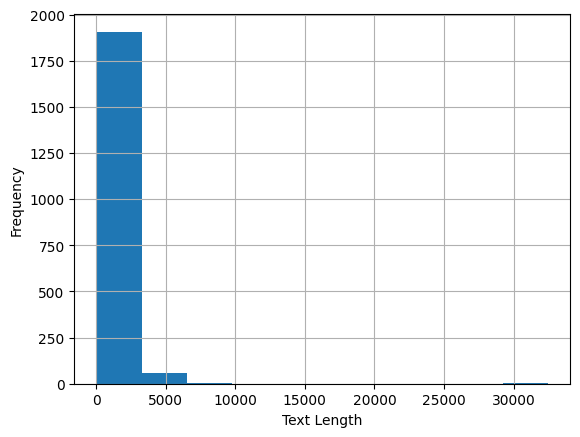

In [139]:
#EDA

#
df['Review'].str.len().hist()
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.title('Length of Text Against Frequency')
plt.show()

#

In [ ]:
X = df["Review"]

y = df['Positive Review']
#Splitting my data

X_train,X_test,y_train,y_test = train_test_split(X,y ,test_size = 0.3,random_state = 1234)

In [160]:
#tf-idf model vectorizing 

tfidf_vectorizer = TfidfVectorizer()


tfidf_vectorizer.fit(X_train)
X_train_tfidf = tfidf_vectorizer.transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

In [ ]:
#Logistic Regression Model training and predicting
lr_model = LogisticRegression()
lr_model.fit(X_train_tfidf, y_train)

y_pred_lr = lr_model.predict(X_test_tfidf)
# Finding model's accuracy
lr_accuracy = accuracy_score(y_test, y_pred_lr)

print(f'Accuracy of our linear regression model : {lr_accuracy}')


In [ ]:
#Random Forest  
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_tfidf,y_train)

y_pred_rf = rf_model.predict(X_test_tfidf)

rf_accuracy = accuracy_score(y_test,y_pred_rf)

print(f'Accuracy of our linear regression model : {rf_accuracy}')

f1 = f1_score(y_test, y_pred_rf)
print(f"F1 Score: {f1}")

cm = confusion_matrix(y_test,y_pred_rf)
print(cm)

In [ ]:
#hyperparameter tuning for LR
param_grid ={
    'C' :[10**i for i in range(-5,5)]
}


print('Running Grid Search...')


grid = GridSearchCV(lr_model, param_grid, cv=5)

grid_search = grid.fit(X_train_tfidf,y_train)
print('Done')

In [ ]:
best_C = grid_search.best_params_['C']

best_C

In [ ]:
#training the best logistic regresison model 
lr_model_best = LogisticRegression(max_iter = 1000,C = best_C)
lr_model_best.fit(X_train_tfidf,y_train)

In [ ]:

#hyperparameter tuning FOR RF
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10]
}


print('Running Grid Search...')


grid = GridSearchCV(rf_model, param_grid, cv=5)

grid_search = grid.fit(X_train_tfidf,y_train)
print('Done')


In [ ]:
# best_C = grid_search.best_params_['n_estimators']
rf_model_best = grid_search.best_estimator_

rf_model_best

In [ ]:
estimators = [
    ('lr', lr_model_best), # A tuple: ('name', unfitted_estimator_object)
    ('rf', rf_model_best)  # A tuple: ('name', unfitted_estimator_object)
]
#building my ensemble model
stacked_model = StackingClassifier(estimators = estimators,cv = 5)
stacked_model.fit(X_train_tfidf, y_train)

In [ ]:
y_pred_stack = stacked_model.predict(X_test_tfidf)
stack_accuracy = accuracy_score(y_test, y_pred_stack)

print(f"Accuracy of the stacking model: {stack_accuracy}")


In [ ]:


y_probs = stacked_model.predict_proba(X_test_tfidf)[:, 1]
y_pred = stacked_model.predict(X_test_tfidf)

# Classification report
print(classification_report(y_test, y_pred))

# AUC Score
auc = roc_auc_score(y_test, y_probs)
print(f"AUC Score: {auc:.4f}")

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
plt.plot(fpr, tpr, label=f"AUC = {auc:.2f}")
plt.plot([0,1], [0,1], linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid()
plt.show()

This graph demonstrates that my model demonstrates strong performance in classification. With an overall accuracy of 83%, it correctly predicts outcomes most of the time. Digging deeper, its precision and recall scores (around 83-84%) for both classes are consistent and high, indicating it's reliable in identifying both positive and negative instances without significant bias towards one. Most notably, the AUC score of 0.91, clearly visualized by the ROC curve hugging the top-left corner, signifies that my ensemble model is excellent at distinguishing between the two classes, performing significantly better than random chance.


In [ ]:
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

This confusion matrix reveals your classification model's performance by showing how many predictions were correct versus incorrect for "Negative" and "Positive" categories. Out of 592 total predictions, your model correctly identified 236 true negatives and 219 true positives, resulting in about 76.8% overall accuracy. While generally performing well, the model shows a slight tendency to miss positive instances (87 false negatives) more often than it incorrectly flags negative ones as positive (50 false positives). This means it's more likely to classify a genuinely positive book review as negative than vice-versa, which could lead to good books being overlooked.

In [ ]:

np.random.seed(42)  
sample_indices = np.random.choice(len(X_test), 3, replace=False)

print(" Example Predictions on Test Book Reviews")
print("~ "*80)

for index in sample_indices:
    review_text = X_test.iloc[index]
    true_label = y_test.iloc[index]
    
    vectorized = tfidf_vectorizer.transform([review_text])
    
    predicted_label = stacked_model.predict(vectorized)[0]
    confidence = stacked_model.predict_proba(vectorized)[0][1] 
    
    print("-" * 60)
    print(review_text[:400] + ("..." if len(review_text) > 400 else ""))
    print(f"\n True Label:     {'Positive' if true_label else 'Negative'}")
    print(f" Predicted:      {'Positive' if predicted_label else 'Negative'}")
    print(f" Confidence:     {confidence:.2f}")
    print("~ "*80)


From these three examples, we can see that the stacked model accurately classified all three example book reviews, demonstrating high confidence in its positive predictions (0.81, 0.86) and effectively identifying the negative sentiment with a low positive confidence (0.12), indicating strong performance in discerning both positive and negative tones in the text.
